# Chapter 4

## Simpson's Paradox

Consider a medical setting with binary variables where:
- $X = 1$ indicates the patient took a certain drug for a year
- $Y = 1$ indicates that the patient recovered after one year of taking the drug
- $Z = 1$ indicates the patient is female

In [2]:
from sympy import symbols, Function, Symbol

from src import SymbolicSCM, variables, CausalGraph

## Definition 4.1.1. Interventional Distribution

Given two disjoint sets of variables, $\mathbf X$ and $\mathbf Y$, the causal effect of $\mathbf X$ on $\mathbf Y$, denoted, $P(\mathbf y | do(\mathbf X = \mathbf x))$, is a function from $\mathbf X$ to the space of probability distributions of $\mathbf Y$. For each realization, $\mathbf X = \mathbf x$, $P(\mathbf y | do(\mathbf x))$ gives the probability of $\mathbf Y = \mathbf y$ induced by deleting from the model all equations corresponding to variables in $\mathbf X = \mathbf x$ and substituting $\mathbf X = \mathbf x$ in the remaining equations.

### Example 4.3 - Sprinkler

Consider a classic setting where a robot is in charge of maintaining
the backyard healthy and nourished throughout the entire year. The robot keeps track of the season
($Se$), sprinkler ($Sp$), rain ($Ra$), the wetness of the floor ($We$), and whether it is slippery ($Sl$). The
causal diagram $G$ is shown below and represents the following collection of mechanisms:

$$
\begin{align}
F &= \begin{cases}
    Se &\gets f_{Se}(U_{Se}) \\ 
    Sp &\gets f_{Sp}(Se, U_{Sp}) \\ 
    Ra &\gets f_{Ra}(Se, U_{Ra}) \\ 
    We &\gets f_{We}(Sp, Ra, U_{We}) \\ 
    Sl &\gets f_{Sl}(We, U_{Sl}) \\ 
\end{cases} \\
\end{align}
$$

for some $P(\mathbf U)$.

![Figure 4.6](Fig-4-6.png)

In [3]:
v = se, sp, ra, we, sl = variables('Se Sp Ra We Sl')
f = f_se, f_sp, f_ra, f_we, f_sl = [Function(f'f_{{{k}}}') for k in v]
u = u_se, u_sp, u_ra, u_we, u_sl = variables('U_{se} U_{sp} U_{ra} U_{we} U_{sl}')

m = SymbolicSCM(
    f={
        se: f_se(u_se),
        sp: f_sp(se, u_sp),
        ra: f_ra(se, u_ra),
        we: f_we(sp, ra, u_we),
        sl: f_sl(we, u_sl),
    },
    pu = {
        u_se: 0.5,
        u_sp: 0.5,
        u_ra: 0.5,
        u_we: 0.5,
        u_sl: 0.5,
    }
)

## Definition 4.2.2 - Back-door Criterion

Let $G$ be a causal diagram and $\mathbf X$ and $\mathbf Y$ be the sets of treatment and outcome variable, respectively. A set of variables $\mathbf Z$ is said to satisfy the back-door criterion (BDC) relative to the pair $(\mathbf X, \mathbf Y)$ in $G$ if:

1. No node in $\mathbf Z$ is a descendant of $\mathbf X$, and 
2. $\mathbf Z$ blocks every path between $\mathbf X$ and $\mathbf Y$ that contains an arrow into $\mathbf X$.

### Theorem 4.2.3 - Back-door Adjustment

Let G be a causal diagram and $X$ and $Y$ be the sets of treatment and outcome variables, respectively. If a set of variables $Z$ satisifes the back-door criterion relative to the pair ($X,Y$), the effect of $X$ on $Y$ is identifiable and given by:

$$P(y|do(x)) = \sum_{z}(y|x,z)P(z)$$

### Example 4.3 - Continued

Note that *Rain* satisfies the back-door criterion relative to *Sprinkler* and *Wet*. In particular:

(i) *Rain* is not a descendant of *Sprinkler*, and

(ii) *Rain* blocks the only back-door path from *Sprinkler* to *Wet*

In [4]:
m.graph.is_backdoor_adjustment(
    x=[sp],
    y=[we],
    z=[ra],
    latex=True
)

<IPython.core.display.Latex object>

We can also search for this adjustment:

In [5]:
m.graph.find_backdoor_adjustment(
    x=[sp],
    y=[we],
    included=[ra],
    latex=True
)

<IPython.core.display.Latex object>

### Theorem 4.2.5 - Conditional Back-door Adjustment

Let $G$ be a causal diagram and $\mathbf X, \mathbf Y, \mathbf W$ be the sets of treatment, outcomes, and covariates variables, respectively. If a set of variables $\mathbf Z \cup \mathbf W$ satisfies the back-door criterion relative to the pair $(\mathbf X, \mathbf Y)$, then the $\mathbf W$-specific effect of $\mathbf X$ on $\mathbf Y$ is identifiable and given by:

\begin{equation}
P(\mathbf y | do(\mathbf x), \mathbf w) = \sum_{\mathbf z} P(\mathbf y | \mathbf x, \mathbf z, \mathbf w) P(\mathbf z | \mathbf w)
\end{equation}

### Example 4.4 - Schools and SATs

Consider a study of the results achieved by high school students on their SAT exams. Consider the causal diagram below and suppose $Z_1$ represents the school distict of the student, $Z_2$ the monthly income of her family, and $X$ the type of school they are currently attending, and $Y$ the results obtained by the student in the SAT exam.

Suppose the administration of district $z_1$ is considering whether to increase funding for the charter program, and, therefore, aim to evaluate what is the effect of this type of schools in the students SAT results.

In formal notation, the query can be written as $P(y|do(x),Z_1=z_1)$. We can verify that ${Z_1,Z_2}$ satisfies the BDC, hence the effect is identifiable as:

$$P(y|do(X=charter),Z_1=z_1) = \sum_{z_2}P(y|X=charter,Z_1=z_1,z_2)P(z_2|Z_1=z_1)

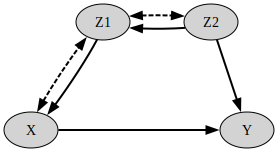

In [6]:
x, y, z1, z2 = variables('X Y Z1 Z2')

ex4_4 = CausalGraph(
    v=[x, y, z1, z2],
    directed_edges=[
        (x, y),
        (z1, x),
        (z2, y),
        (z2, z1),
    ],
    bidirected_edges=[
        (x, z1),
        (z2, z1),
    ],
)


ex4_4.draw(node_positions={
    x: (0, 0),
    y: (3,0),
    z1: (1, 1.5),
    z2: (2.5, 1.5),
})

In [7]:
ex4_4.is_backdoor_adjustment(
    x=[x],
    y=[y],
    z=[z1,z2]
)

True

We can know separate $Z_1$ from the z-set and condition on it instead:

In [8]:
ex4_4.get_backdoor_adjustment_formula(
    x=[x],
    y=[y],
    z=[z2],
    given=[z1],
)

<IPython.core.display.Latex object>

## Definition 4.2.3 - Proper Causal Path

Let $X$ and $Y$ be sets of nodes. A causal path from node $X$ to a node in $Y$ is called proper if it does not intersect $X$, except at the endpoint.

Consider the following causal graph:

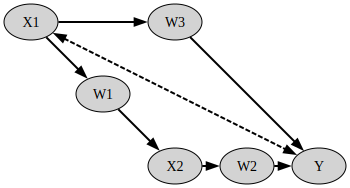

In [9]:
x1, x2, w1, w2, w3, y = variables('X1 X2 W1 W2 W3 Y')

fig4_13 = CausalGraph(
    v=[x1, x2, w1, w2, w3, y],
    directed_edges=[
        (x1, w1),
        (x2, w2),
        (w1, x2),
        (w2, y),
        (x1,w3),
        (w3, y),
    ],
    bidirected_edges=[
        (x1, y),
    ],
)
fig4_13.draw(node_positions={
    x1: (0, 0),
    x2: (2,-2),
    w1: (1, -1),
    w2: (3, -2),
    w3: (2, 0),
    y: (4, -2),
})

We can find the proper causal paths as follows:

In [10]:
fig4_13.find_all_proper_causal_paths(
    x=[x1,x2],
    y=[y],
    full_path=True,
)

[[X1, W3, Y], [X2, W2, Y]]

## Definition 4.2.4 - Adjustment Back-door Criterion (A-BDC)

$Z$ satisifies the A-BDC relative to $X,Y$ in the causal diagram $G$:

(i) No element in $Z$ is a descendant in $G_{do(x)}$ of any $W \notin X$ which lies on a proper causal path from $X$ to $Y$

(ii) All non-causal paths in the $G$ from $X$ to $Y$ are blocked by $Z$

Consider the following causal graph:

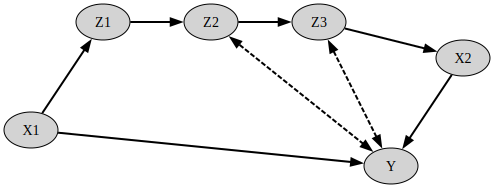

In [11]:
x1, x2, y, z1, z2, z3= variables('X1 X2 Y Z1 Z2 Z3')

fig4_14 = CausalGraph(
    v=[x1, x2, y, z1, z2, z3],
    directed_edges=[
        (x1, z1),
        (z1, z2),
        (z2, z3),
        (z3, x2),
        (x2, y),
        (x1, y),
    ],
    bidirected_edges=[
        (z2,y),
        (z3,y)
    ]
)

fig4_14.draw(node_positions={
    x1: (0, -2),
    x2: (6, -1),
    y: (5, -2.5),
    z1: (1, -.5),
    z2: (2.5, -.5),
    z3: (4, -.5),
})

If we attempt to apply the rules of Def 4.2.2, we find that there is no backdoor admissible set. However, when applying the rules of Def 4.2.4 we find that there is an acceptable backdoor set:

In [12]:
fig4_14.find_all_backdoor_adjustments(x={x1, x2}, y=y)

[{Z1, Z3}, {Z1, Z2, Z3}]

In [13]:
fig4_14.get_backdoor_adjustment_formula(
    x=[x1, x2],
    y=y,
    z=[z1, z3]
)

<IPython.core.display.Latex object>

## Definition 4.2.5 - Front-door Criterion

Let $G$ be a causal diagram and $X$ and $Y$ be the sets of treatment and outcome variables, respectively. A set of variables $Z$ is said to satisfy the front-door criterion (FDC, for short) relative to the pair ($X,Y$) in $G$ if the following conditions hold:

(i) $Z$ intercepts all directed paths from $X$ to $Y$

(ii) There is no unblocked back-door path from $X$ to $X$; and

(iii) All back-door paths from $Z$ to $Y$ are blocked by $X$

### Theorem 4.2.14 - Front-door Adjustment

Let $G$ be a causal diagram and $X$ and $Y$ be the sets of treatment and outcome variables, respectively. If a set of variables $Z$ satisfies the FDC relative to the pair ($X,Y$), the effect of $X$ on $Y$ is identifiable and given by:

$$P(y|do(x)) = \sum_{z}P(z|x)\sum_{x'}P(y|x',z)P(x')$$

## Definition 4.2.6 - Generalized Front-door Criterion

Let $G$ be a causal diagram and $X$ and $Y$ be the sets of treatment and outcomes variables, respectively. A tuple of sets of variables ($Z,Z_1,Z_2$) is said to satisfy the generalized front-door criterion (g-FDC) relative to the pair ($X,Y$) in $G$ if the following conditions hold:

(i) $Z$ intercepts all directed paths from $X$ to $Y$;

(ii) $Z_1$ is back-door admissible relative to ($X,Z$); and

(iii) $Z_2$ is back-door admissible relative to ($Z,Y$)

### Theorem 4.2.15 - Generalized Front-door Adjustment

Let $G$ be a causal diagram and $X$ and
$Y$ be the sets of treatment and outcomes variables, respectively. If
a tuple of sets of variables ($Z,Z_1,Z_2$) satisfies the generalized front-door criterion relative to the pair ($X,Y$), the effect of $X$ on $Y$ is identifiable and given by:

$$P(y|do(x)) = \sum_z \sum_{z_1} P(z|x,z_1)P(z_1)\sum_{x',z_2}P(y|x',z,z_2)P(x',z_2)$$

Consider the causal diagram below:

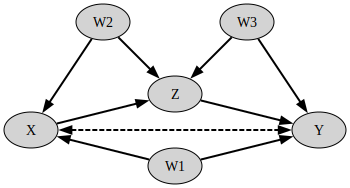

In [14]:
x, z, y, w1, w2, w3 = variables('X Z Y W1 W2 W3')

fig4_24 = CausalGraph(
    v=[x, z, y, w1, w2, w3],
    directed_edges=[
        (x, z),
        (z, y),
        (w1, y),
        (w1,x),
        (w2, x),
        (w2, z),
        (w3, z),
        (w3, y)
    ],
    bidirected_edges=[
        (x,y)
    ]
)

fig4_24.draw(
    node_positions={
        x: (0, -.5),
        z: (2, 0),
        y: (4, -.5),
        w1: (2, -1),
        w2: (1, 1),
        w3: (3, 1)
    }
)

In [15]:
fig4_24.find_all_backdoor_adjustments(x={x}, y=y) is None

True

In [16]:
fig4_24.find_all_frontdoor_adjustments(
    x={x},
    y=y,
)

[([Z], [W2], [W3]), ([Z], [W2], [W3, W1]), ([Z], [W1, W2], [W3])]

In [17]:
fig4_24.get_frontdoor_adjustment_formula(
    x={x},
    y=y,
    z=[z],
    xz=[w2],
    zy=[w3],
)

<IPython.core.display.Latex object>